In [3]:
#!pip install tensorflow
#!pip install -U homeharvest

In [1]:
import pandas as pd
from homeharvest import scrape_property
from datetime import datetime

# Sweet Home Project — Clean Notebook
**Home price prediction with Gradient Boosting (+ Ridge residual stacking)**  
_Erdős Deep Learning Bootcamp • Jiayi Liu_

## Objectives
- Predict residential **`sold_price`** using listing features + geography.  
- Evaluate **two scenarios**: **with** and **without** `list_price`.  
- Compare **GBDT** vs **DNN** (baseline), then **improve GBDT** via **Ridge residual stacking** in log-space.  
- Use a **time-aware 5-fold CV** with **65/15/20** (train/val/test).  
- Report **MAE**, **R²**, plus **calibration** (slope/intercept).


# Data Scraping & Cleaning
**Data Scraping**
1. Scrape year to date sold homes in NJ from Redfind. 
2. Dropoff unnecessary columns. 

**Cleaning:**
1. Normalize column names.
2. Parse time fields.
3. Coerce numeric-like columns.
4. Remove obvious leakage columns and IDs/URLs.
5. Select target (`sold_price` if present else `list_price`) and drop missing target rows.


### Scrape year to date sold homes in NJ from Redfind

In [3]:
# Generate filename based on current timestamp
#current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#filename = f"HomeHarvest_{current_timestamp}.csv"

properties_raw = scrape_property(
  location="New Jersey",
  listing_type="sold",  # or (for_sale, for_rent, pending)
  #past_days=30,  # sold in last 30 days - listed in last 30 days if (for_sale, for_rent)

  # property_type=['single_family','multi_family'],
   date_from="2025-01-01", # alternative to past_days
   date_to="2025-11-04",
  foreclosure=False,
  mls_only=True,  # only fetch MLS listings
)
print(f"Number of properties: {len(properties_raw)}")


print(properties_raw.head())

Number of properties: 7168
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  6526700315  2985129909   
1  https://www.realtor.com/realestateandhomes-det...  6130073112  2985465069   
2  https://www.realtor.com/realestateandhomes-det...  5185497486  2987075917   
3  https://www.realtor.com/realestateandhomes-det...  5379425599  2986468736   
4  https://www.realtor.com/realestateandhomes-det...  6879627684  2984419992   

                                           permalink   mls       mls_id  \
0  35-E-Bayview-Ave_Ocean-Gate_NJ_08740_M65267-00315  MONJ     22523836   
1      818-Martin-St_Elizabeth_NJ_07201_M61300-73112  GSNJ      3981987   
2       532-Randolph-St_Camden_NJ_08105_M51854-97486  PHPA  NJCD2103192   
3    14-Bongart-Dr_West-Orange_NJ_07052_M53794-25599  GSNJ      3987419   
4  54-Nosenzo-Pond-Rd_West-Milford_NJ_07480_M6879...  GSNJ      3976176   

  status mls_status                      

In [4]:
# Preview raw data
pd.set_option('display.max_columns', None)
display(properties_raw.head())

,property_url,property_id,listing_id,permalink,mls,mls_id,status,mls_status,text,style,formatted_address,full_street_line,street,unit,city,state,zip_code,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_price,list_price_min,list_price_max,list_date,pending_date,sold_price,last_sold_date,last_sold_price,assessed_value,estimated_value,tax,tax_history,new_construction,lot_sqft,price_per_sqft,latitude,longitude,neighborhoods,county,fips_code,stories,hoa_fee,parking_garage,agent_id,agent_name,agent_email,agent_phones,agent_mls_set,agent_nrds_id,broker_id,broker_name,builder_id,builder_name,office_id,office_mls_set,office_name,office_email,office_phones,nearby_schools,primary_photo,alt_photos
0,https://www.realtor.com/realestateandhomes-det...,6526700315,2985129909,35-E-Bayview-Ave_Ocean-Gate_NJ_08740_M65267-00315,MONJ,22523836,SOLD,Sold,"Charming, bright, and well maintained Cape jus...",SINGLE_FAMILY,"35 E Bayview Ave, Ocean Gate, NJ, 08740",35 E Bayview Ave,35 E Bayview Ave,<NA>,Ocean Gate,NJ,08740,3,1,<NA>,1024,1932,88,399900,<NA>,<NA>,2025-08-07 22:08:44,2025-08-19 15:51:08,430000,2025-11-04 00:00:00,430000,287900,396000,5242,"[{'assessment': {'building': 136900, 'land': 1...",False,3920,420,39.927837,-74.139137,<NA>,Ocean,34029,1,0,NaN,1285571,Cessna Statt,CessnaStatt@remax.net,"[{'ext': None, 'primary': True, 'type': 'Mobil...",A-MONJ-12524,610500380,1285973,RE/MAX AT BARNEGAT BAY,<NA>,<NA>,1285500,O-MONJ-1227,RE MAX At Barnegat Bay,forkedriver@rbbre.com,"[{'number': '6096935002', 'type': 'Office', 'p...","Central Regional School District, Berkeley Tow...",https://ap.rdcpix.com/9c3b7eb16af8971411e527b5...,https://ap.rdcpix.com/9c3b7eb16af8971411e527b5...
1,https://www.realtor.com/realestateandhomes-det...,6130073112,2985465069,818-Martin-St_Elizabeth_NJ_07201_M61300-73112,GSNJ,3981987,SOLD,Sold,What a fantastic opportunity to own a fully oc...,MULTI_FAMILY,"818 Martin St, Elizabeth City, NJ, 07201",818 Martin St,818 Martin St,<NA>,Elizabeth City,NJ,07201,5,3,<NA>,19998,<NA>,76,535000,<NA>,<NA>,2025-08-19 00:11:34,2025-09-03 20:46:02,535000,2025-11-04 00:00:00,535000,21200,<NA>,6205,"[{'assessment': {'building': 15500, 'land': 57...",False,2178000,27,40.659704,-74.201171,North End,Union,34039,2,<NA>,NaN,1501908,JOSE QUISPE,jose.quispe@hotmail.com,"[{'ext': None, 'primary': True, 'type': 'Mobil...",A-GSNJ-274841,85822537,<NA>,Weichert Realtors-Quispe & Associates,<NA>,<NA>,<NA>,O-GSNJ-5766,WEICHERT REALTORS- QUISPE & ASSOC,<NA>,"[{'number': '9084691111', 'type': 'Office', 'p...",Elizabeth Public School District,https://ap.rdcpix.com/16dd6c213025e73a6437b8cd...,https://ap.rdcpix.com/16dd6c213025e73a6437b8cd...
2,https://www.realtor.com/realestateandhomes-det...,5185497486,2987075917,532-Randolph-St_Camden_NJ_08105_M51854-97486,PHPA,NJCD2103192,SOLD,Sold,This is a great opportunity for investors and ...,TOWNHOMES,"532 Randolph St, Camden, NJ, 08105",532 Randolph St,532 Randolph St,<NA>,Camden,NJ,08105,3,1,<NA>,1162,1940,28,146000,<NA>,<NA>,2025-10-06 14:25:28,<NA>,150000,2025-11-04 00:00:00,150000,61900,130700,2282,"[{'assessment': {'building': 43800, 'land': 18...",False,1742,129,39.939089,-75.089313,Marlton,Camden,34007,2,0,NaN,1290176,Michael Diggs,mikedworking4u@kw.com,"[{'ext': None, 'primary': True, 'type': 'Offic...",A-PHPA-3180777,<NA>,2265299,Keller Williams Realty - Moorestown,<NA>,<NA>,2048205,O-PHPA-55528,Keller Williams Realty - Moorestown,klrw984@kw.com,"[{'number': '8563161100', 'type': 'Office', 'p...",Camden City Public School District,https://ap.rdcpix.com/72ea1f8d957bfbfe71b8122d...,https://ap.rdcpix.com/72ea1f8d957bfbfe71b8122d...
3,https://www.realtor.com/realestateandhomes-det...,5379425599,2986468736,14-Bongart-Dr_West-Orange_NJ_07052_M53794-25599,GSNJ,3987419,SOLD,Sold,Welcome to this rarely available Prestwick Ran...,CONDOS,"14 Bongart Dr, West Orange, NJ, 07052",14 Bongart Dr,14 Bongart Dr,<NA>,West Orange,NJ,07052,3,3,<NA>,<NA>,1990,47,549000,<NA>,<NA>,2025-09-17 16:45:16,2025-10-01 15:27:30,

### Dropoff unnecessary columns.

In [5]:
columns_to_drop = [
    'status', "mls_status", "state", 
    'property_url', 'property_id', 'listing_id', 'permalink', 'mls',
    'mls_id', 'text', 'formatted_address', 'full_street_line', 'street',
    'unit', 'last_sold_date',
    'tax_history', 'agent_id', 'agent_name',
    'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id',
    'broker_id', 'broker_name', 'builder_id',
    'office_mls_set', 'office_name', 'office_email', 'office_phones',
    'primary_photo', 'alt_photos', 'list_price_min', 'list_price_max', 
    'builder_name', 
]

properties = properties_raw.drop(columns=columns_to_drop)
display(properties.head())

,style,city,zip_code,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_price,list_date,pending_date,sold_price,last_sold_price,assessed_value,estimated_value,tax,new_construction,lot_sqft,price_per_sqft,latitude,longitude,neighborhoods,county,fips_code,stories,hoa_fee,parking_garage,office_id,nearby_schools
0,SINGLE_FAMILY,Ocean Gate,08740,3,1,<NA>,1024,1932,88,399900,2025-08-07 22:08:44,2025-08-19 15:51:08,430000,430000,287900,396000,5242,False,3920,420,39.927837,-74.139137,<NA>,Ocean,34029,1,0,NaN,1285500,"Central Regional School District, Berkeley Tow..."
1,MULTI_FAMILY,Elizabeth City,07201,5,3,<NA>,19998,<NA>,76,535000,2025-08-19 00:11:34,2025-09-03 20:46:02,535000,535000,21200,<NA>,6205,False,2178000,27,40.659704,-74.201171,North End,Union,34039,2,<NA>,NaN,<NA>,Elizabeth Public School District
2,TOWNHOMES,Camden,08105,3,1,<NA>,1162,1940,28,146000,2025-10-06 14:25:28,<NA>,150000,150000,61900,130700,2282,False,1742,129,39.939089,-75.089313,Marlton,Camden,34007,2,0,NaN,2048205,Camden City Public School District
3,CONDOS,West Orange,07052,3,3,<NA>,<NA>,1990,47,549000,2025-09-17 16:45:16,2025-10-01 15:27:30,661000,661000,<NA>,580361,<NA>,False,12197,<NA>,40.778629,-74.238792,Orange,Essex,34013,2,504,2.0,641899,Essex County Vocational Technical School Distr...
4,SINGLE_FAMILY,West Milford,07480,3,2,1,<NA>,1951,108,474500,2025-07-18 15:15:16,2025-08-08 22:24:37,469335,469335,199700,477449,8095,False,14810,<NA>,41.083403,-74.382518,<NA>,Passaic,34031,<NA>,0,NaN,44061,West Milford Township Public School District


In [7]:
numeric_object_cols = [
    'beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls',
    'list_price', 'assessed_value', 'estimated_value',
    'latitude', "longitude", 
    'tax', 'lot_sqft', 'price_per_sqft', 'stories', 'hoa_fee'
]

for col in numeric_object_cols:
    properties[col] = pd.to_numeric(properties[col], errors='coerce')

#print("Data types after numeric conversion:")
#print(properties.dtypes)

#print("\nNumber of null values for converted columns:")
#print(properties[numeric_object_cols].isnull().sum())


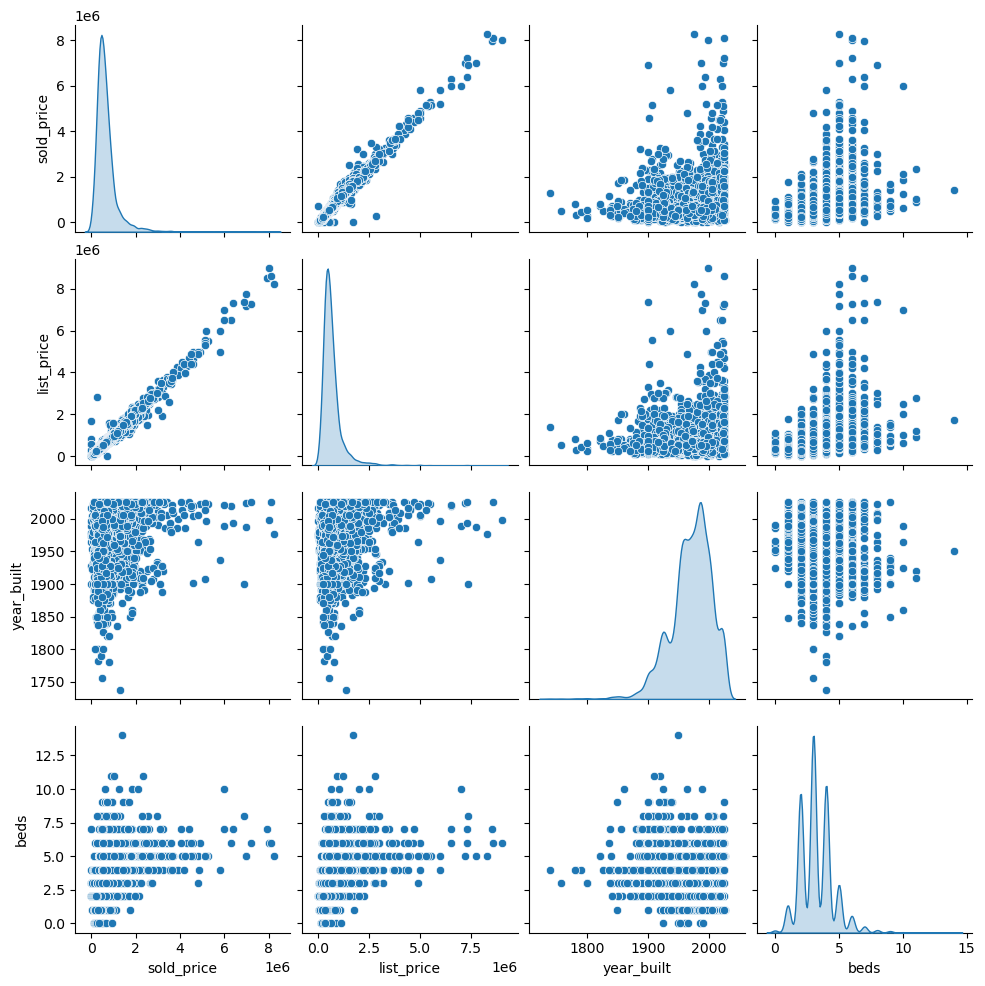

In [8]:
import seaborn as sns

sns.pairplot(properties[['sold_price', 'list_price', 'year_built', 'beds']], diag_kind='kde')

# Models and comparison
## GBDT vs DNN

=== 5-FOLD 65/15/20 — WITH list_price ===
GBDT + list_price | Fold 1 | train= 1433 val= 1075 test= 1433 | fit= 1.27s pred= 0.01s | VAL  MAE=48,336 R2=0.901 | TEST MAE=60,797 R2=0.847
GBDT + list_price | Fold 2 | train= 2866 val= 1075 test= 1433 | fit= 1.22s pred= 0.01s | VAL  MAE=49,629 R2=0.914 | TEST MAE=48,817 R2=0.917
GBDT + list_price | Fold 3 | train= 4299 val= 1075 test= 1433 | fit= 1.52s pred= 0.01s | VAL  MAE=43,646 R2=0.944 | TEST MAE=35,915 R2=0.957
GBDT + list_price | Fold 4 | train= 4660 val= 1075 test= 1433 | fit= 1.39s pred= 0.01s | VAL  MAE=40,587 R2=0.949 | TEST MAE=33,177 R2=0.948
GBDT + list_price | Fold 5 | train= 4660 val= 1075 test= 1433 | fit= 1.38s pred= 0.01s | VAL  MAE=40,587 R2=0.949 | TEST MAE=33,177 R2=0.948
-----
GBDT + list_price 
            VAL_MAE    VAL_R2      TEST_MAE   TEST_R2     VAL_MedAE  \
mean  44556.966087  0.931192  42376.617300  0.923702  19429.317760   
std    4253.090698  0.022441  12163.547487  0.045279   1740.337482   

        TEST_Med

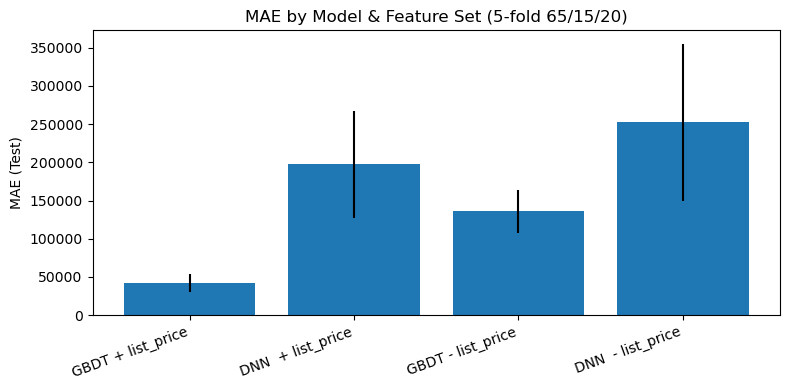

In [12]:
# =========================================================
# 5-fold time-based CV with 65/15/20 (train/val/test)
# Models:
#   - GBDT (HistGradientBoostingRegressor)
#   - Keras DNN (log1p target, BN+Dropout, early stopping)
# Variants: WITH and WITHOUT list_price
# Reports: MAE, R2 (+ MedAE, RMSE, trimmed MAPE), per-fold and averaged
# Also prints a compact comparison table and a quick MAE bar plot
# =========================================================

import numpy as np, pandas as pd, time, warnings, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from datetime import datetime
from pandas.api.types import is_integer_dtype, is_bool_dtype

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------
# 0) Prep dataframe
# -----------------------
df = properties.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# parse dates for time order (sold_date > pending_date > list_date)
for c in ["list_date","pending_date","sold_date"]:
    if c in df.columns:
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True).tz_convert(None)
        except Exception:
            df[c] = pd.to_datetime(df[c], errors="coerce")

tcol = next((c for c in ["sold_date","pending_date","list_date"]
             if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c])), None)
if tcol is not None:
    df = df.sort_values(tcol).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# choose target
target = "sold_price" if "sold_price" in df.columns else "list_price"
df = df[~df[target].isna()].copy()

# helpful light features
if "year_built" in df.columns:
    df["age"] = pd.to_numeric(df["year_built"], errors="coerce")
    df["age"] = datetime.now().year - df["age"]
if {"latitude","longitude"}.issubset(df.columns):
    df["lat_2"] = pd.to_numeric(df["latitude"], errors="coerce").round(2)
    df["lon_2"] = pd.to_numeric(df["longitude"], errors="coerce").round(2)
if "nearby_schools" in df.columns:
    df["nearby_schools_n"] = df["nearby_schools"].astype(str).map(
        lambda x: 0 if x in ("nan","None","") else x.count(",")+1
    )

# base X, y
X_full = df.drop(columns=[target], errors="ignore").copy()
y_full = pd.to_numeric(df[target], errors="coerce").to_numpy()

# drop leakers/ids/text
for bad in ["sold_price","last_sold_price","estimated_value","assessed_value","price_per_sqft",
            "address","full_address","street","url","source","mls_id","listing_id","id",
            "nearby_schools"]:
    if bad in X_full.columns:
        X_full.drop(columns=bad, inplace=True, errors="ignore")

# normalize pandas nullable types
X_full.replace({pd.NA: np.nan}, inplace=True)
for c in X_full.columns:
    if is_integer_dtype(X_full[c]) or is_bool_dtype(X_full[c]):
        X_full[c] = X_full[c].astype("float64")

# two variants
X_with_lp    = X_full.copy()
X_without_lp = X_full.drop(columns="list_price", errors="ignore").copy()

# -----------------------
# 1) 5 folds: 65/15/20 expanding window
# -----------------------
def five_fold_time_split_indices(n: int, val_frac: float = 0.15):
    test_len = max(1, n // 5)                      # ~20%
    val_len  = max(1, int(round(val_frac * n)))    # 15%
    folds = []
    end = val_len + test_len
    while end <= n and len(folds) < 5:
        tr_end = end - (val_len + test_len)
        if tr_end > 0:
            tr_idx = np.arange(0, tr_end)
            va_idx = np.arange(tr_end, tr_end + val_len)
            te_idx = np.arange(tr_end + val_len, end)
            folds.append((tr_idx, va_idx, te_idx))
        end += test_len
    # adjust to ensure exactly 5 folds if rounding shorted us
    while len(folds) < 5 and folds:
        last_end = folds[-1][2][-1] + 1
        new_end = min(n, last_end + test_len)
        tr_end = new_end - (val_len + test_len)
        if tr_end <= 0: break
        tr_idx = np.arange(0, tr_end)
        va_idx = np.arange(tr_end, tr_end + val_len)
        te_idx = np.arange(tr_end + val_len, new_end)
        folds.append((tr_idx, va_idx, te_idx))
    return folds

# -----------------------
# 2) Preprocessor + models
# -----------------------
def build_preprocessor(Xtr_df: pd.DataFrame):
    num_cols = Xtr_df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = Xtr_df.select_dtypes(exclude=[np.number]).columns.tolist()
    for c in cat_cols:
        Xtr_df[c] = Xtr_df[c].astype("object")
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse=False)
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc",  StandardScaler())]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("ohe", ohe)]), cat_cols)
        ],
        sparse_threshold=0.0
    )
    return pre

def build_gbdt():
    return HistGradientBoostingRegressor(
        learning_rate=0.08, max_iter=400, min_samples_leaf=25, random_state=1337
    )

def make_ann(input_dim: int):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return m

# -----------------------
# 3) Helper metrics
# -----------------------
def rmse(y, p): return float(np.sqrt(np.mean((p - y)**2)))
def trimmed_mape(y, p, eps=1000.0):
    y = np.array(y, float); p = np.array(p, float)
    mask = np.abs(y) >= eps
    if mask.sum() == 0: return np.nan
    return float(np.mean(np.abs((p[mask]-y[mask])/y[mask])) * 100.0)

# -----------------------
# 4) Runner for one model on one variant
# -----------------------
def run_cv(model_name, X_df, y, use_dnn=False):
    n = len(X_df)
    folds = five_fold_time_split_indices(n, val_frac=0.15)
    res = []
    for i, (tr, va, te) in enumerate(folds, 1):
        Xtr, Xva, Xte = X_df.iloc[tr].copy(), X_df.iloc[va].copy(), X_df.iloc[te].copy()
        ytr, yva, yte = y[tr], y[va], y[te]

        pre = build_preprocessor(Xtr.copy())
        Xtr_m = pre.fit_transform(Xtr); Xva_m = pre.transform(Xva); Xte_m = pre.transform(Xte)

        if not use_dnn:
            # --------- GBDT ---------
            model = build_gbdt()
            t0 = time.perf_counter(); model.fit(Xtr_m, ytr); t1 = time.perf_counter()
            pva = model.predict(Xva_m); pte = model.predict(Xte_m); t2 = time.perf_counter()
        else:
            # --------- DNN (log target) ---------
            ytr_log = np.log1p(np.clip(ytr, 0, None)).astype("float32")
            model = make_ann(Xtr_m.shape[1])
            es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=0)
            t0 = time.perf_counter()
            model.fit(Xtr_m, ytr_log, validation_split=0.1, epochs=200, batch_size=1024, callbacks=[es], verbose=0)
            t1 = time.perf_counter()
            pva_log = model.predict(Xva_m, verbose=0).ravel()
            pte_log = model.predict(Xte_m, verbose=0).ravel()
            # clip to train log-range
            lo, hi = np.quantile(ytr_log, [0.001, 0.999])
            pva_log = np.clip(pva_log, lo-0.5, hi+0.5)
            pte_log = np.clip(pte_log, lo-0.5, hi+0.5)
            pva = np.expm1(pva_log); pte = np.expm1(pte_log)
            t2 = time.perf_counter()

        mae_v = mean_absolute_error(yva, pva)
        r2_v  = r2_score(yva, pva)
        mae_t = mean_absolute_error(yte, pte)
        r2_t  = r2_score(yte, pte)
        med_v = median_absolute_error(yva, pva)
        med_t = median_absolute_error(yte, pte)
        rmse_v= rmse(yva, pva)
        rmse_t= rmse(yte, pte)
        tmape_v = trimmed_mape(yva, pva)
        tmape_t = trimmed_mape(yte, pte)

        print(f"{model_name} | Fold {i} | train={len(tr):5d} val={len(va):5d} test={len(te):5d} | "
              f"fit={t1-t0:5.2f}s pred={t2-t1:5.2f}s | "
              f"VAL  MAE={mae_v:,.0f} R2={r2_v:.3f} | "
              f"TEST MAE={mae_t:,.0f} R2={r2_t:.3f}")

        res.append({
            "fold": i, "fit_s": t1-t0, "pred_s": t2-t1,
            "VAL_MAE": mae_v, "VAL_R2": r2_v, "VAL_MedAE": med_v, "VAL_RMSE": rmse_v, "VAL_tMAPE%": tmape_v,
            "TEST_MAE": mae_t, "TEST_R2": r2_t, "TEST_MedAE": med_t, "TEST_RMSE": rmse_t, "TEST_tMAPE%": tmape_t
        })

    df_res = pd.DataFrame(res)
    summ = df_res[["VAL_MAE","VAL_R2","TEST_MAE","TEST_R2","VAL_MedAE","TEST_MedAE","VAL_RMSE","TEST_RMSE","VAL_tMAPE%","TEST_tMAPE%"]].agg(["mean","std"])
    print("-----")
    print(model_name, "\n", summ)
    return df_res, summ

# -----------------------
# 5) Run all 4 experiments
# -----------------------
print("=== 5-FOLD 65/15/20 — WITH list_price ===")
gbdt_with_df, gbdt_with_sum = run_cv("GBDT + list_price", X_with_lp, y_full, use_dnn=False)
dnn_with_df,  dnn_with_sum  = run_cv("DNN  + list_price", X_with_lp, y_full, use_dnn=True)

print("\n=== 5-FOLD 65/15/20 — WITHOUT list_price ===")
gbdt_wo_df, gbdt_wo_sum = run_cv("GBDT - list_price", X_without_lp, y_full, use_dnn=False)
dnn_wo_df,  dnn_wo_sum  = run_cv("DNN  - list_price", X_without_lp, y_full, use_dnn=True)

# -----------------------
# 6) Compact comparison table (TEST metrics)
# -----------------------
def grab(rowname, summ):
    return {
        "TEST_MAE_mean": float(summ.loc["mean","TEST_MAE"]),
        "TEST_MAE_std":  float(summ.loc["std","TEST_MAE"]),
        "TEST_R2_mean":  float(summ.loc["mean","TEST_R2"]),
        "TEST_R2_std":   float(summ.loc["std","TEST_R2"])
    }

comp = pd.DataFrame({
    "GBDT + list_price": grab("GBDT + list_price", gbdt_with_sum),
    "DNN  + list_price": grab("DNN  + list_price",  dnn_with_sum),
    "GBDT - list_price": grab("GBDT - list_price",  gbdt_wo_sum),
    "DNN  - list_price": grab("DNN  - list_price",  dnn_wo_sum),
}).T

print("\n=== TEST SUMMARY (5-fold, 65/15/20) ===")
print(comp.to_string(float_format=lambda x: f"{x:,.3f}"))

# -----------------------
# 7) Quick visualization (MAE)
# -----------------------
labels = comp.index.tolist()
mae_means = comp["TEST_MAE_mean"].values
mae_stds  = comp["TEST_MAE_std"].values

plt.figure(figsize=(8,4))
plt.bar(range(len(labels)), mae_means, yerr=mae_stds)
plt.xticks(range(len(labels)), labels, rotation=20, ha="right")
plt.ylabel("MAE (Test)")
plt.title("MAE by Model & Feature Set (5-fold 65/15/20)")
plt.tight_layout()
plt.show()


## Improving GBDT — Ridge Residual Stacking (log-space)
Mathematics:
- Base prediction: \( \hat y_{\text{base}} )\
- Residual target: \( r = \log(1+y) - \log(1+\hat y_{\text{base}}) \) (winsorized 1–99%)
- Enhancer features: encoded **X** plus \( \hat y_{\text{base}} \) and \( \log(1+\hat y_{\text{base}}) \)
- Stacked prediction: \( \hat y_{\text{stack}} = \exp( \log(1+\hat y_{\text{base}})+\hat r ) - 1 \)
- Blend: \( \hat y_{\text{final}} = (1-\alpha)\hat y_{\text{base}} + \alpha\hat y_{\text{stack}} \)  
  with closed-form \(\alpha\) on VAL + **do-no-harm** fallback.


In [39]:
# =========================================================
# STEP 2: Gradient Boosting + Residual Enhancer (DNN or Ridge)
# 5-fold, time-aware 65/15/20 (train/val/test), WITH & WITHOUT list_price
# - Multiplicative residuals in log space
# - DNN enhancer (Huber) or Ridge linear enhancer (toggle CHOICE below)
# - Alpha blending on validation + do-no-harm fallback
# - Reports per-fold Base→Final and CV summaries
# =========================================================

import numpy as np, pandas as pd, time, warnings
warnings.filterwarnings("ignore")
from datetime import datetime

from pandas.api.types import is_integer_dtype, is_bool_dtype
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge

# ---- Optional: set enhancer type here ----
ENHANCER = "ridge"   # choices: "dnn" or "ridge"

# Keras only needed if using DNN enhancer
if ENHANCER == "dnn":
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, regularizers

# -----------------------
# 0) Prep dataframe
# -----------------------
df = properties.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

for c in ["list_date","pending_date","sold_date"]:
    if c in df.columns:
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True).tz_convert(None)
        except Exception:
            df[c] = pd.to_datetime(df[c], errors="coerce")

tcol = next((c for c in ["sold_date","pending_date","list_date"]
             if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c])), None)
df = df.sort_values(tcol).reset_index(drop=True) if tcol is not None else df.reset_index(drop=True)

target = "sold_price" if "sold_price" in df.columns else "list_price"
df = df[~df[target].isna()].copy()

# light features
if "year_built" in df.columns:
    df["age"] = pd.to_numeric(df["year_built"], errors="coerce")
    df["age"] = datetime.now().year - df["age"]
if {"latitude","longitude"}.issubset(df.columns):
    df["lat_2"] = pd.to_numeric(df["latitude"], errors="coerce").round(2)
    df["lon_2"] = pd.to_numeric(df["longitude"], errors="coerce").round(2)
if "nearby_schools" in df.columns:
    df["nearby_schools_n"] = df["nearby_schools"].astype(str).map(
        lambda x: 0 if x in ("nan","None","") else x.count(",")+1
    )

X_full = df.drop(columns=[target], errors="ignore").copy()
y_full = pd.to_numeric(df[target], errors="coerce").to_numpy()

# drop leakers/IDs/text
for bad in ["sold_price","last_sold_price","estimated_value","assessed_value","price_per_sqft",
            "address","full_address","street","url","source","mls_id","listing_id","id",
            "nearby_schools"]:
    if bad in X_full.columns:
        X_full.drop(columns=bad, inplace=True, errors="ignore")

# normalize pandas nullable types
X_full.replace({pd.NA: np.nan}, inplace=True)
for c in X_full.columns:
    if is_integer_dtype(X_full[c]) or is_bool_dtype(X_full[c]):
        X_full[c] = X_full[c].astype("float64")

X_with_lp    = X_full.copy()
X_without_lp = X_full.drop(columns="list_price", errors="ignore").copy()

# -----------------------
# 1) 5-fold time split: 65/15/20
# -----------------------
def five_fold_time_split_indices(n: int, val_frac: float = 0.15):
    test_len = max(1, n // 5)                      # ~20%
    val_len  = max(1, int(round(val_frac * n)))    # 15%
    folds = []
    end = val_len + test_len
    while end <= n and len(folds) < 5:
        tr_end = end - (val_len + test_len)
        if tr_end > 0:
            tr_idx = np.arange(0, tr_end)
            va_idx = np.arange(tr_end, tr_end + val_len)
            te_idx = np.arange(tr_end + val_len, end)
            folds.append((tr_idx, va_idx, te_idx))
        end += test_len
    while len(folds) < 5 and folds:
        last_end = folds[-1][2][-1] + 1
        new_end = min(n, last_end + test_len)
        tr_end = new_end - (val_len + test_len)
        if tr_end <= 0: break
        tr_idx = np.arange(0, tr_end)
        va_idx = np.arange(tr_end, tr_end + val_len)
        te_idx = np.arange(tr_end + val_len, new_end)
        folds.append((tr_idx, va_idx, te_idx))
    return folds

# -----------------------
# 2) Preprocessor + models
# -----------------------
def build_preprocessor(Xtr_df: pd.DataFrame):
    num_cols = Xtr_df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = Xtr_df.select_dtypes(exclude=[np.number]).columns.tolist()
    for c in cat_cols:
        Xtr_df[c] = Xtr_df[c].astype("object")
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=20, sparse=False)
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc",  StandardScaler())]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("ohe", ohe)]), cat_cols)
        ],
        sparse_threshold=0.0
    )
    return pre

def build_gbdt():
    return HistGradientBoostingRegressor(
        learning_rate=0.08, max_iter=400, min_samples_leaf=25, random_state=1337
    )

def build_dnn(input_dim: int):
    l2 = 1e-4
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(0.10),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(0.05),
        layers.Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=7e-4, clipnorm=1.0)
    m.compile(optimizer=opt, loss=keras.losses.Huber(delta=0.5))
    return m

# -----------------------
# 3) One run (WITH or WITHOUT list_price)
# -----------------------
def run_stack_variant(X_df, y, label: str):
    n = len(X_df)
    folds = five_fold_time_split_indices(n, val_frac=0.15)

    base_mae, base_r2, fin_mae, fin_r2 = [], [], [], []
    t_base, t_enh, t_tot = [], [], []

    for i, (tr, va, te) in enumerate(folds, 1):
        Xtr, Xva, Xte = X_df.iloc[tr].copy(), X_df.iloc[va].copy(), X_df.iloc[te].copy()
        ytr, yva, yte = y[tr], y[va], y[te]

        # Preprocess
        pre = build_preprocessor(Xtr.copy())
        Xtr_m = pre.fit_transform(Xtr)
        Xva_m = pre.transform(Xva)
        Xte_m = pre.transform(Xte)

        # --- Base model ---
        base = build_gbdt()
        t0 = time.perf_counter()
        base.fit(Xtr_m, ytr)
        base_tr = base.predict(Xtr_m)
        base_va = base.predict(Xva_m)
        base_te = base.predict(Xte_m)
        t1 = time.perf_counter()

        b_mae = mean_absolute_error(yva, base_va)
        b_r2  = r2_score(yva, base_va)
        base_mae.append(b_mae); base_r2.append(b_r2)

        # --- Residual target in log-space (multiplicative) ---
        eps = 1.0
        r_tr = np.log1p(np.clip(ytr, 0, None)) - np.log1p(np.clip(base_tr, 0, None))
        # clamp residuals to robust range
        r_lo, r_hi = np.quantile(r_tr, [0.01, 0.99])
        r_lo, r_hi = float(r_lo - 0.1), float(r_hi + 0.1)
        r_tr = np.clip(r_tr, r_lo, r_hi)

        # Enhancer features: original features + base pred
        Xtr_aug = np.hstack([Xtr_m, base_tr.reshape(-1,1)])
        Xva_aug = np.hstack([Xva_m, base_va.reshape(-1,1)])
        Xte_aug = np.hstack([Xte_m, base_te.reshape(-1,1)])

        # --- Train enhancer ---
        if ENHANCER == "ridge":
            enh = Ridge(alpha=1.0, fit_intercept=True, random_state=1337)
            t2 = time.perf_counter()
            enh.fit(Xtr_aug, r_tr)
            r_va = enh.predict(Xva_aug)
            r_te = enh.predict(Xte_aug)
            t3 = time.perf_counter()
        else:
            enh = build_dnn(Xtr_aug.shape[1])
            es  = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0)
            t2 = time.perf_counter()
            enh.fit(Xtr_aug, r_tr.astype("float32"), validation_split=0.1,
                    epochs=80, batch_size=2048, callbacks=[es], verbose=0)
            r_va = enh.predict(Xva_aug, verbose=0).ravel().astype("float64")
            r_te = enh.predict(Xte_aug, verbose=0).ravel().astype("float64")
            t3 = time.perf_counter()

        # clip predicted residuals to same corridor
        r_va = np.clip(r_va, r_lo, r_hi)
        r_te = np.clip(r_te, r_lo, r_hi)

        # --- Compose final preds (multiplicative correction) ---
        va_stack = np.expm1(np.log1p(np.clip(base_va, 0, None)) + r_va)
        te_stack = np.expm1(np.log1p(np.clip(base_te, 0, None)) + r_te)

        # --- Alpha blending on validation (choose best alpha in [0..1]) ---
        alphas = np.linspace(0.0, 1.0, 21)
        best_alpha, best_mae = 0.0, 1e18
        for a in alphas:
            cand = (1-a)*base_va + a*va_stack
            mae_a = mean_absolute_error(yva, cand)
            if mae_a < best_mae:
                best_mae, best_alpha = mae_a, a

        va_final = (1-best_alpha)*base_va + best_alpha*va_stack
        te_final = (1-best_alpha)*base_te + best_alpha*te_stack

        f_mae = mean_absolute_error(yva, va_final)
        f_r2  = r2_score(yva, va_final)

        # do-no-harm: if worse than base by >0.2%, keep base
        if f_mae > b_mae * 1.002:
            va_final, te_final = base_va, base_te
            f_mae, f_r2 = b_mae, b_r2
            note = "fallback"
        else:
            note = f"blend α={best_alpha:.2f}"

        # report on TEST using chosen strategy
        final_mae = mean_absolute_error(yte, te_final)
        final_r2  = r2_score(yte, te_final)
        fin_mae.append(final_mae); fin_r2.append(final_r2)

        t_base.append(t1 - t0); t_enh.append(t3 - t2); t_tot.append((t1 - t0) + (t3 - t2))

        print(f"{label} | Fold {i} | train={len(tr):5d} val={len(va):5d} test={len(te):5d} | "
              f"Base fit={t1-t0:5.2f}s Enh fit={t3-t2:5.2f}s Total={t_tot[-1]:5.2f}s | "
              f"Base VAL MAE={b_mae:,.0f} R2={b_r2:.3f}  →  Final VAL MAE={f_mae:,.0f} R2={f_r2:.3f} ({note}) | "
              f"TEST MAE={final_mae:,.0f} R2={final_r2:.3f}")

    print("-----")
    print(f"{label} BASE  VAL: MAE {np.mean(base_mae):,.0f} ± {np.std(base_mae):,.0f} | "
          f"R2 {np.mean(base_r2):.3f} ± {np.std(base_r2):.3f}")
    print(f"{label} FINAL VAL: MAE {np.mean(fin_mae):,.0f} ± {np.std(fin_mae):,.0f} | "
          f"R2 {np.mean(fin_r2):.3f} ± {np.std(fin_r2):.3f}")
    print(f"{label} Time (per fold): base {np.mean(t_base):.2f}±{np.std(t_base):.2f}s | "
          f"enh {np.mean(t_enh):.2f}±{np.std(t_enh):.2f}s | total {np.mean(t_tot):.2f}±{np.std(t_tot):.2f}s")

    return {
        "BASE_VAL_MAE": base_mae, "BASE_VAL_R2": base_r2,
        "FINAL_TEST_MAE": fin_mae, "FINAL_TEST_R2": fin_r2
    }

# -----------------------
# 4) Run WITH and WITHOUT list_price
# -----------------------
print(f"=== STACKED RESIDUALS ({ENHANCER.upper()}) — WITH list_price ===")
res_with = run_stack_variant(X_with_lp, y_full, label=f"STACK+LP[{ENHANCER}]")

print(f"\n=== STACKED RESIDUALS ({ENHANCER.upper()}) — WITHOUT list_price ===")
res_wo = run_stack_variant(X_without_lp, y_full, label=f"STACK-noLP[{ENHANCER}]")


=== STACKED RESIDUALS (RIDGE) — WITH list_price ===
STACK+LP[ridge] | Fold 1 | train= 1460 val= 1095 test= 1460 | Base fit= 0.89s Enh fit= 0.21s Total= 1.10s | Base VAL MAE=46,882 R2=0.907  →  Final VAL MAE=43,214 R2=0.937 (blend α=1.00) | TEST MAE=52,172 R2=0.905
STACK+LP[ridge] | Fold 2 | train= 2920 val= 1095 test= 1460 | Base fit= 0.99s Enh fit= 0.06s Total= 1.05s | Base VAL MAE=47,222 R2=0.908  →  Final VAL MAE=43,035 R2=0.950 (blend α=1.00) | TEST MAE=39,824 R2=0.966
STACK+LP[ridge] | Fold 3 | train= 4380 val= 1095 test= 1460 | Base fit= 1.34s Enh fit= 0.01s Total= 1.35s | Base VAL MAE=36,989 R2=0.972  →  Final VAL MAE=35,475 R2=0.977 (blend α=1.00) | TEST MAE=35,950 R2=0.946
STACK+LP[ridge] | Fold 4 | train= 4747 val= 1095 test= 1460 | Base fit= 1.23s Enh fit= 0.01s Total= 1.24s | Base VAL MAE=39,370 R2=0.949  →  Final VAL MAE=37,881 R2=0.955 (blend α=1.00) | TEST MAE=31,290 R2=0.965
STACK+LP[ridge] | Fold 5 | train= 4747 val= 1095 test= 1460 | Base fit= 1.22s Enh fit= 0.01s Tot

=== FINAL WITH list_price: GBDT + Ridge residual ===
STACK+LP[ridge] | Fold 1 | train= 1460 val= 1095 test= 1460 | Base fit= 1.08s Enh fit= 0.00s Total= 1.08s | Base VAL MAE=46,882 R2=0.907  →  Final VAL MAE=43,214 R2=0.937 (blend α=1.00) | TEST MAE=52,172 R2=0.905
STACK+LP[ridge] | Fold 2 | train= 2920 val= 1095 test= 1460 | Base fit= 0.99s Enh fit= 0.00s Total= 0.99s | Base VAL MAE=47,222 R2=0.908  →  Final VAL MAE=43,035 R2=0.950 (blend α=1.00) | TEST MAE=39,824 R2=0.966
STACK+LP[ridge] | Fold 3 | train= 4380 val= 1095 test= 1460 | Base fit= 1.25s Enh fit= 0.01s Total= 1.26s | Base VAL MAE=36,989 R2=0.972  →  Final VAL MAE=35,475 R2=0.977 (blend α=1.00) | TEST MAE=35,950 R2=0.946
STACK+LP[ridge] | Fold 4 | train= 4747 val= 1095 test= 1460 | Base fit= 1.22s Enh fit= 0.01s Total= 1.22s | Base VAL MAE=39,370 R2=0.949  →  Final VAL MAE=37,881 R2=0.955 (blend α=1.00) | TEST MAE=31,290 R2=0.965
STACK+LP[ridge] | Fold 5 | train= 4747 val= 1095 test= 1460 | Base fit= 1.33s Enh fit= 0.01s To

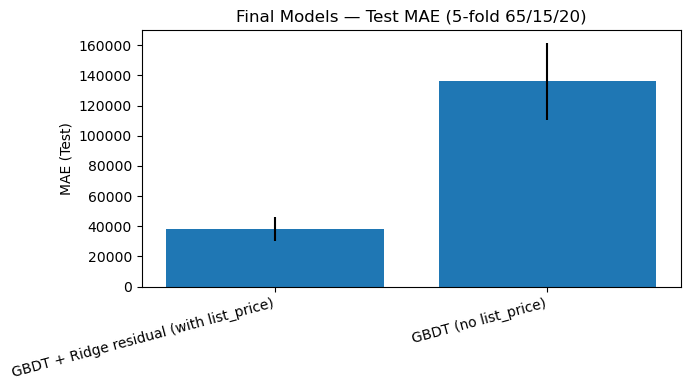

In [40]:
# FINAL COMPARISON: Base GBDT vs. Ridge-Stack (WITH/WO list_price)
# Assumes the Step-2 code (stacked residuals) is in the notebook already.
# If you kept the `run_stack_variant` function and the five-fold splitter,
# we’ll call it twice and summarize.

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Ensure ENHANCER="ridge" and all helper fns are already defined in the notebook,
# then reuse X_with_lp, X_without_lp, y_full from earlier cells:

print("=== FINAL WITH list_price: GBDT + Ridge residual ===")
ENHANCER = "ridge"
res_with = run_stack_variant(X_with_lp, y_full, label="STACK+LP[ridge]")

print("\n=== FINAL WITHOUT list_price: Base GBDT only (enhancer may abstain) ===")
res_wo = run_stack_variant(X_without_lp, y_full, label="STACK-noLP[ridge]")

# Build a compact table on TEST metrics
def agg(res, name):
    return pd.Series({
        "TEST_MAE_mean": np.mean(res["FINAL_TEST_MAE"]),
        "TEST_MAE_std":  np.std(res["FINAL_TEST_MAE"]),
        "TEST_R2_mean":  np.mean(res["FINAL_TEST_R2"]),
        "TEST_R2_std":   np.std(res["FINAL_TEST_R2"]),
    }, name=name)

summary = pd.concat([
    agg(res_with, "GBDT + Ridge residual (with list_price)"),
    agg(res_wo,   "GBDT (no list_price)"),
], axis=1).T

print("\n=== FINAL TEST SUMMARY (5-fold, 65/15/20) ===")
print(summary.to_string(float_format=lambda x: f"{x:,.3f}"))

# Quick bar chart for MAE
plt.figure(figsize=(7,4))
plt.bar(range(len(summary)), summary["TEST_MAE_mean"], yerr=summary["TEST_MAE_std"])
plt.xticks(range(len(summary)), summary.index, rotation=15, ha="right")
plt.ylabel("MAE (Test)")
plt.title("Final Models — Test MAE (5-fold 65/15/20)")
plt.tight_layout()
plt.show()


Saved:
 - fold_preds_with_list_price.csv
 - fold_preds_without_list_price.csv
GBDT + Ridge residual (WITH list_price) [VAL]  MAE=38,536  R2=0.962  |  calib: y ≈ 0.985·ŷ + 2,100


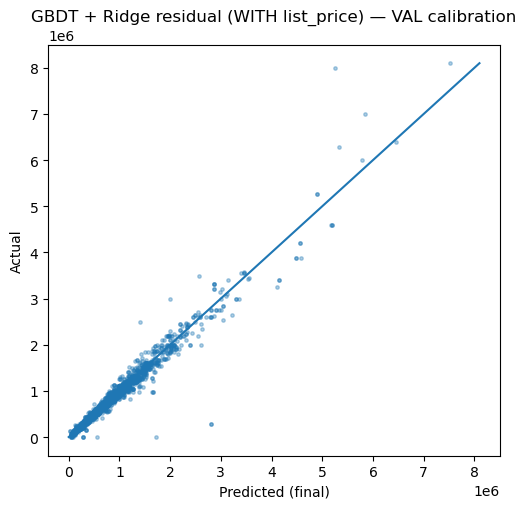

GBDT + Ridge residual (WITH list_price) [TEST]  MAE=36,913  R2=0.954  |  calib: y ≈ 1.003·ŷ + -9,701


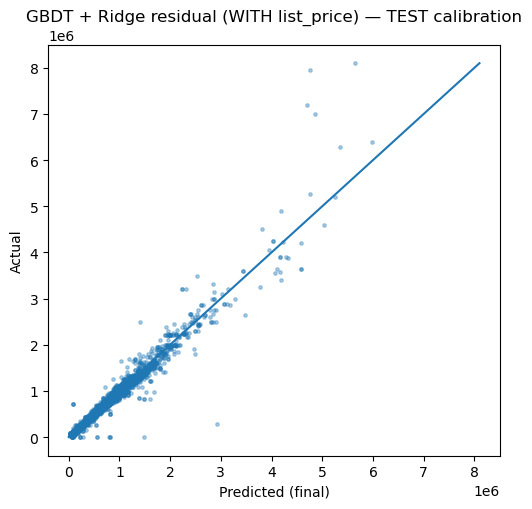

GBDT + Ridge residual (WITHOUT list_price) [VAL]  MAE=143,160  R2=0.702  |  calib: y ≈ 0.907·ŷ + 47,533


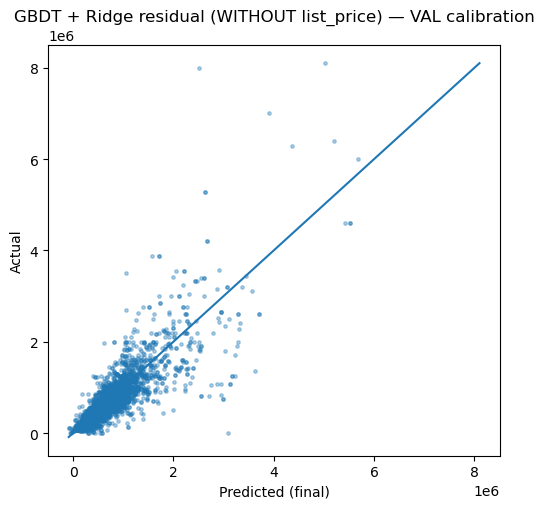

GBDT + Ridge residual (WITHOUT list_price) [TEST]  MAE=136,444  R2=0.670  |  calib: y ≈ 0.932·ŷ + 31,670


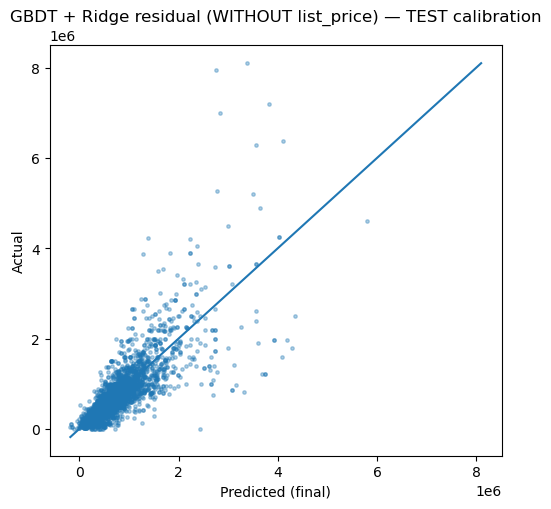

In [41]:
# ================================================
# Export fold-level predictions + calibration plots
# Final models: GBDT + Ridge residual (log-space)
# WITH and WITHOUT list_price
# ================================================

import numpy as np, pandas as pd, time, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

def run_and_collect_preds(X_df, y, variant_label: str):
    folds = five_fold_time_split_indices(len(X_df), val_frac=0.15)
    rows = []
    for i, (tr, va, te) in enumerate(folds, 1):
        Xtr, Xva, Xte = X_df.iloc[tr].copy(), X_df.iloc[va].copy(), X_df.iloc[te].copy()
        ytr, yva, yte = y[tr], y[va], y[te]

        pre = build_preprocessor(Xtr.copy())
        Xtr_m = pre.fit_transform(Xtr); Xva_m = pre.transform(Xva); Xte_m = pre.transform(Xte)

        # Base GBDT
        base = build_gbdt()
        base.fit(Xtr_m, ytr)
        p_tr = base.predict(Xtr_m)
        p_va = base.predict(Xva_m)
        p_te = base.predict(Xte_m)

        # Log-space residual corridor
        r_tr = np.log1p(np.clip(ytr, 0, None)) - np.log1p(np.clip(p_tr, 0, None))
        r_lo, r_hi = np.quantile(r_tr, [0.01, 0.99])
        r_lo, r_hi = float(r_lo - 0.1), float(r_hi + 0.1)
        r_tr = np.clip(r_tr, r_lo, r_hi)

        # Augment with base preds + log base pred
        p_tr_log = np.log1p(np.clip(p_tr, 0, None)).reshape(-1,1)
        p_va_log = np.log1p(np.clip(p_va, 0, None)).reshape(-1,1)
        p_te_log = np.log1p(np.clip(p_te, 0, None)).reshape(-1,1)

        Xtr_aug = np.hstack([Xtr_m, p_tr.reshape(-1,1), p_tr_log])
        Xva_aug = np.hstack([Xva_m, p_va.reshape(-1,1), p_va_log])
        Xte_aug = np.hstack([Xte_m, p_te.reshape(-1,1), p_te_log])

        # Ridge enhancer on residuals
        enh = Ridge(alpha=1.0, fit_intercept=True, random_state=1337)
        enh.fit(Xtr_aug, r_tr)
        rv = enh.predict(Xva_aug); rt = enh.predict(Xte_aug)
        rv = np.clip(rv, r_lo, r_hi); rt = np.clip(rt, r_lo, r_hi)

        # Multiplicative correction
        va_stack = np.expm1(np.log1p(np.clip(p_va, 0, None)) + rv)
        te_stack = np.expm1(np.log1p(np.clip(p_te, 0, None)) + rt)

        # Closed-form alpha on validation (blend between base and stacked)
        diff = (va_stack - p_va)
        num  = np.sum(diff * (yva - p_va))
        den  = np.sum(diff * diff) + 1e-12
        alpha_star = num / den
        alpha = float(np.clip(alpha_star, -0.25, 1.50))

        p_va_final = (1 - alpha) * p_va + alpha * va_stack
        p_te_final = (1 - alpha) * p_te + alpha * te_stack

        # do-no-harm guard
        if mean_absolute_error(yva, p_va_final) > mean_absolute_error(yva, p_va) * 1.002:
            p_va_final, p_te_final = p_va, p_te
            alpha_note = "fallback"
        else:
            alpha_note = f"alpha={alpha:.2f}"

        # collect fold rows (validation + test)
        rows.append(pd.DataFrame({
            "fold": i,
            "idx": np.arange(len(yva)),
            "split": "val",
            "y": yva,
            "yhat_base": p_va,
            "yhat_final": p_va_final,
            "alpha_note": alpha_note,
            "variant": variant_label
        }))
        rows.append(pd.DataFrame({
            "fold": i,
            "idx": np.arange(len(yte)),
            "split": "test",
            "y": yte,
            "yhat_base": p_te,
            "yhat_final": p_te_final,
            "alpha_note": alpha_note,
            "variant": variant_label
        }))

    out = pd.concat(rows, ignore_index=True)
    return out

# ---- Run both variants and save CSVs ----
preds_with  = run_and_collect_preds(X_with_lp,    y_full, "with_list_price")
preds_wo    = run_and_collect_preds(X_without_lp, y_full, "without_list_price")

preds_with.to_csv("fold_preds_with_list_price.csv", index=False)
preds_wo.to_csv("fold_preds_without_list_price.csv", index=False)

print("Saved:")
print(" - fold_preds_with_list_price.csv")
print(" - fold_preds_without_list_price.csv")

# ---- Calibration + pooled metrics helper ----
def pooled_report_and_plot(preds, title_prefix=""):
    for split in ["val","test"]:
        dfp = preds[preds["split"] == split].copy()
        # pooled metrics (final)
        mae = mean_absolute_error(dfp["y"], dfp["yhat_final"])
        r2  = r2_score(dfp["y"], dfp["yhat_final"])

        # calibration slope/intercept: regress y on yhat_final
        x = dfp["yhat_final"].to_numpy()
        y = dfp["y"].to_numpy()
        # guard against degenerate variance
        if np.std(x) < 1e-8:
            slope, intercept = 1.0, 0.0
        else:
            slope, intercept = np.polyfit(x, y, 1)

        print(f"{title_prefix} [{split.upper()}]  MAE={mae:,.0f}  R2={r2:.3f}  |  calib: y ≈ {slope:.3f}·ŷ + {intercept:,.0f}")

        # scatter + y=x
        plt.figure(figsize=(5.2,5.2))
        plt.scatter(dfp["yhat_final"], dfp["y"], s=6, alpha=0.35)
        lims = [
            min(dfp["y"].min(), dfp["yhat_final"].min()),
            max(dfp["y"].max(), dfp["yhat_final"].max())
        ]
        plt.plot(lims, lims)
        plt.xlabel("Predicted (final)")
        plt.ylabel("Actual")
        plt.title(f"{title_prefix} — {split.upper()} calibration")
        plt.tight_layout()
        plt.show()

# ---- Pooled reports + calibration plots ----
pooled_report_and_plot(preds_with, title_prefix="GBDT + Ridge residual (WITH list_price)")
pooled_report_and_plot(preds_wo,   title_prefix="GBDT + Ridge residual (WITHOUT list_price)")
